In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter  
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error  


In [69]:
path = '/Users/iamyoungjin/Desktop/Nottingham Modules/Term1/ML/Assignment2/TrainDataset2023.xls'
df = pd.read_excel(path)
df = df.drop('ID', axis=1)
# change "999" to NaN
df.replace(999, pd.NA, inplace=True)

# Finding missing value 
columns_with_missing_values = df.columns[df.isnull().any()]
df = df.dropna()

pCR_label = df['pCR (outcome)'] # Classlification Label
RelapseFreeSurvival_label = df['RelapseFreeSurvival (outcome)'] # Regression Label
df = df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)


In [70]:
columns_minmax_encode = ['Age'] + df.columns[10:].tolist()
columns_onehot_encode = df.columns[1:5].tolist() + df.columns[7:9].tolist()
columns_label_encode = df.columns[5:7].tolist() + [df.columns[9]]

# Min-Max Scaling 
scaler = MinMaxScaler()
df[columns_minmax_encode] = scaler.fit_transform(df[columns_minmax_encode])

# One-Hot Encoding
df = pd.get_dummies(df, columns=columns_onehot_encode)

# Label Encoding
label_encoder = LabelEncoder()

for col in columns_label_encode:
    df[col] = label_encoder.fit_transform(df[col])


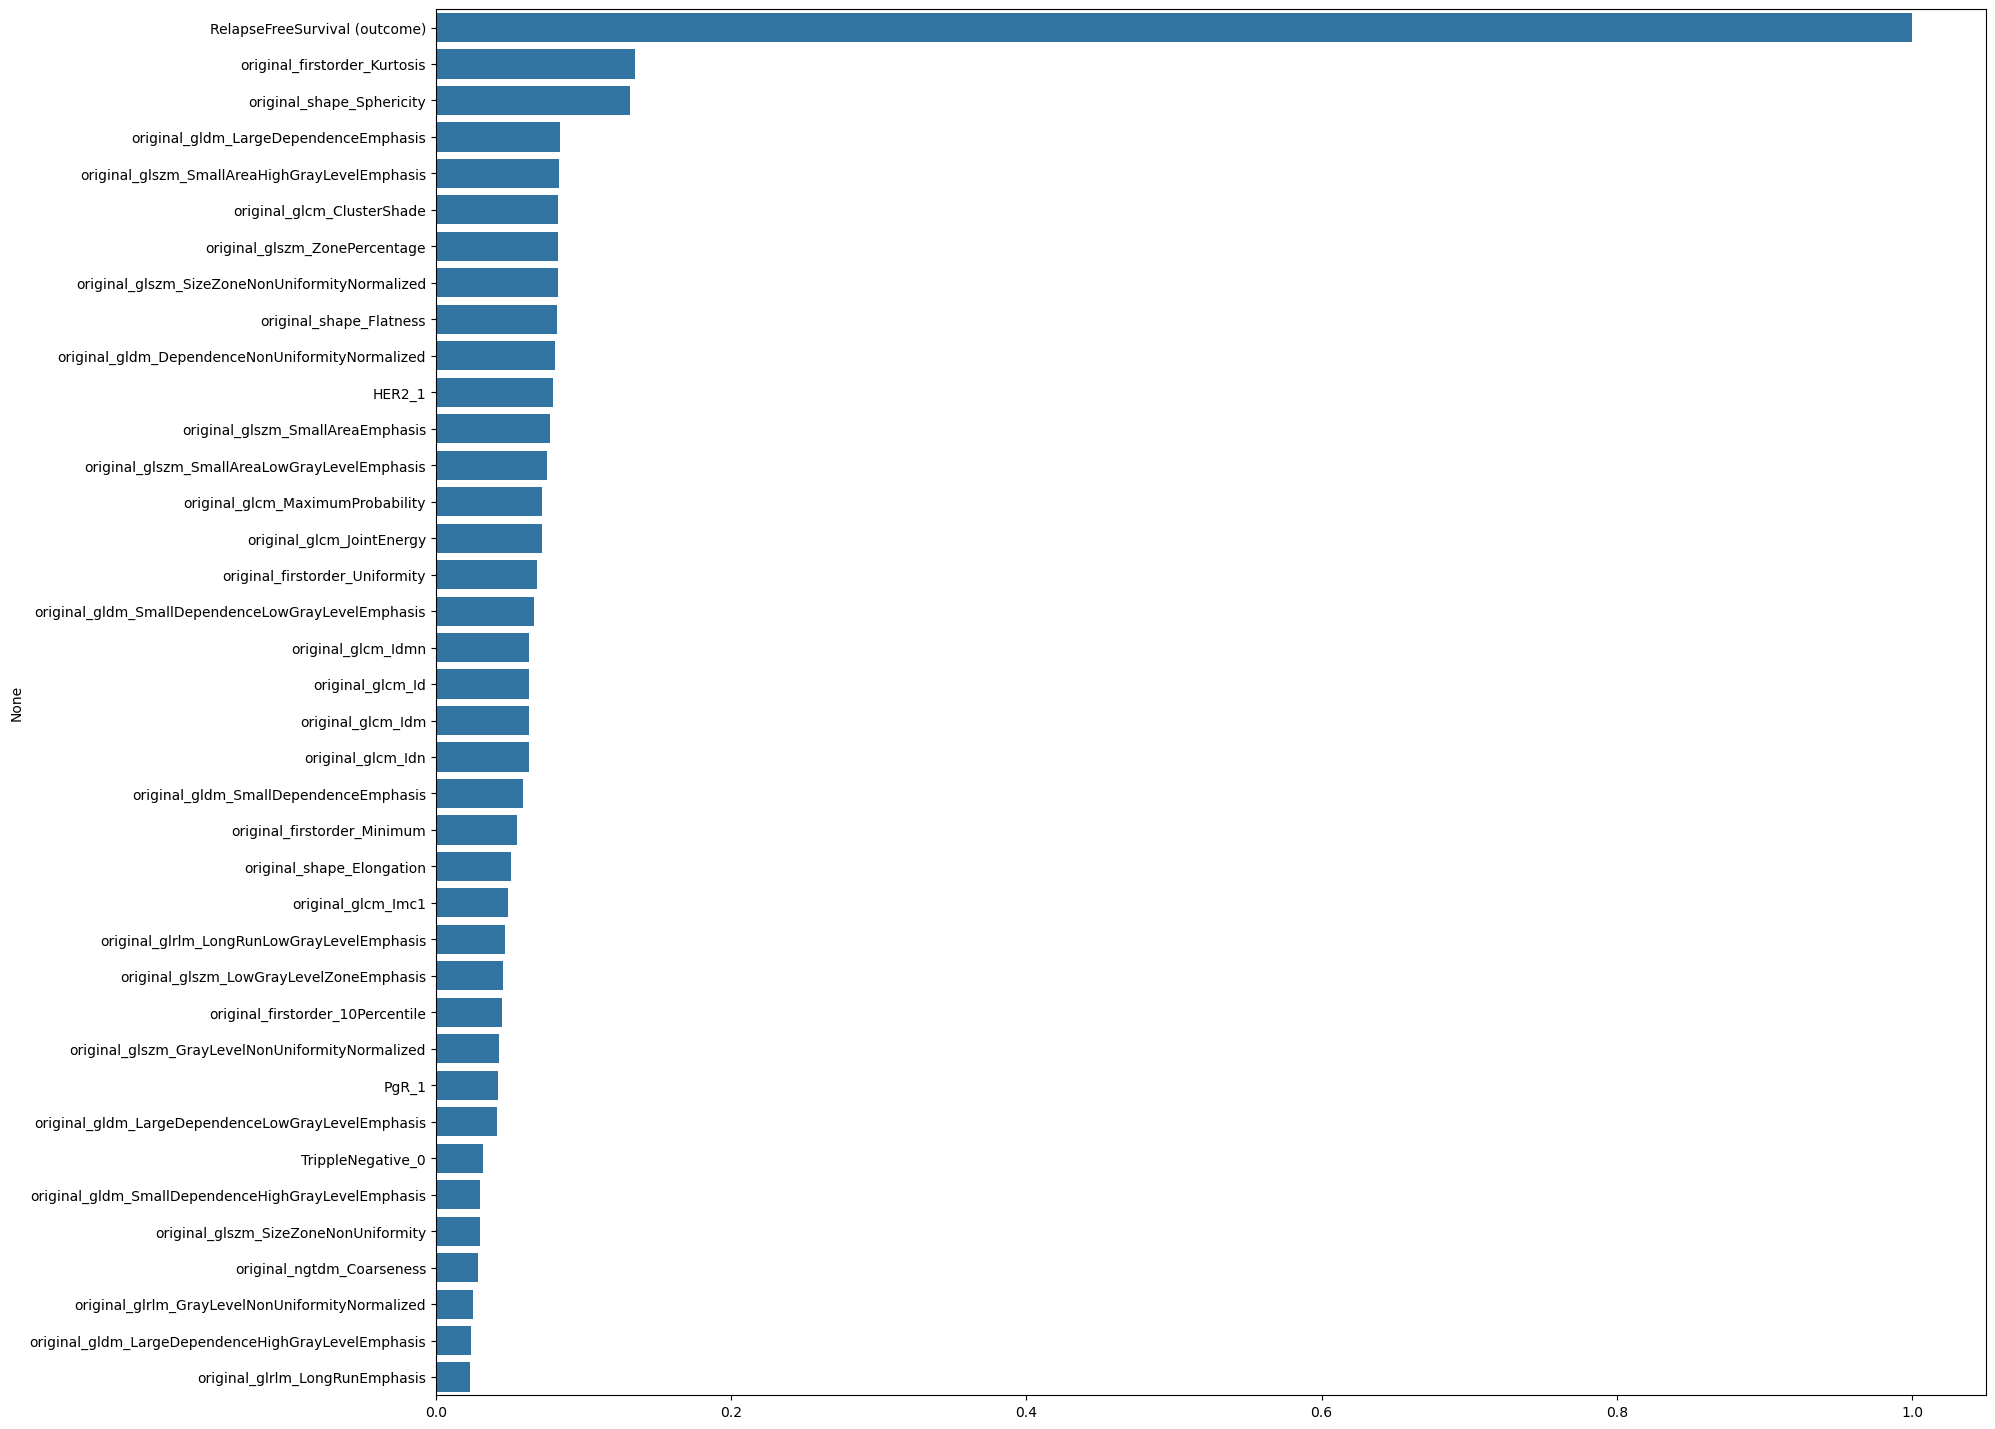

In [71]:
target = ['RelapseFreeSurvival (outcome)' ]
#target = ['pCR (outcome)']

high_corr_lst = []
for idx in range(len(target)):
    if idx == 0:
        df = pd.concat([df, RelapseFreeSurvival_label],axis=1)
    else:
        df = pd.concat([df, RelapseFreeSurvival_label], axis=1)
    corr_matrix = df.corr()
    
    threshold = 0.02

    col = corr_matrix[target[idx]] >= threshold
    high_corr_columns = corr_matrix.columns[col]
    high_corr_lst.append(high_corr_columns)

    high_corr_matrix = df[high_corr_columns].corr()
    # print(high_corr_matrix)
    order = high_corr_matrix.loc[target[idx]].sort_values(ascending=False).index

    plt.figure(figsize=(20, 18))
    sns.barplot(x=high_corr_matrix.loc[target[idx]].loc[order].values, y=order)
    plt.show()


In [72]:
len(high_corr_lst[0])
df_high_corr = df[high_corr_columns]

In [73]:
import torch.nn.functional as F

class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

class LinearRegressionModel1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearRegressionModel1, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        return self.layer2(x)

class LinearRegressionModel2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super(LinearRegressionModel2, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        return self.layer2(x)


In [74]:
# Example data preprocessing
high_corr_X = df_high_corr.values
high_corr_y = RelapseFreeSurvival_label.values

high_corr_X = high_corr_X.astype(np.float32)
high_corr_y = high_corr_y.astype(np.float32)  # Assuming your regression target is a float

# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

criterion = nn.MSELoss()
epochs = 60
lr = 0.001
hidden_size = 64#128 #64
input_size = high_corr_X.shape[1]
output_size = 1

mse_lst = []
r2_lst = []
mae_lst = []

for train_idx, test_idx in kf.split(high_corr_X):
    X_train, X_test = high_corr_X[train_idx], high_corr_X[test_idx]
    y_train, y_test = high_corr_y[train_idx], high_corr_y[test_idx]

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    model = LinearRegressionModel2(input_size, hidden_size, output_size, dropout_rate=0.2)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor.view(-1, 1))
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        predictions = model(X_test_tensor).squeeze().numpy()

        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)

        mse_lst.append(mse)
        r2_lst.append(r2)
        mae_lst.append(mae)

        print(f'Mean Squared Error: {mse}, R2 Score: {r2}, Mean Absolute Error: {mae}')

print(f'Average Mean Squared Error: {np.mean(mse_lst)}')
print(f'Average R2 Score: {np.mean(r2_lst)}')
print(f'Average Mean Absolute Error: {np.mean(mae_lst)}')


Mean Squared Error: 1932.4110107421875, R2 Score: -1.0153031826801242, Mean Absolute Error: 38.03457260131836
Mean Squared Error: 1513.015869140625, R2 Score: -1.4402469016320034, Mean Absolute Error: 34.91511917114258
Mean Squared Error: 1167.5250244140625, R2 Score: -1.0598415079303112, Mean Absolute Error: 30.72941017150879
Mean Squared Error: 1526.96044921875, R2 Score: -0.8773319212689807, Mean Absolute Error: 34.13957214355469
Mean Squared Error: 1113.0487060546875, R2 Score: -0.5895761971468323, Mean Absolute Error: 29.096019744873047
Average Mean Squared Error: 1450.5921630859375
Average R2 Score: -0.9964599421316503
Average Mean Absolute Error: 33.382938385009766


In [75]:
X_resampled, y_resampled = RandomOverSampler().fit_resample(high_corr_X, high_corr_y)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [49]:
# Example data preprocessing
high_corr_X = X_resampled
high_corr_y = y_resampled

high_corr_X = high_corr_X.astype(np.float32)
high_corr_y = high_corr_y.astype(np.float32)  # Assuming your regression target is a float

# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

criterion = nn.MSELoss()
epochs = 60
lr = 0.001
hidden_size = 128 #64
input_size = high_corr_X.shape[1]
output_size = 1

mse_lst = []
r2_lst = []
mae_lst = []

for train_idx, test_idx in kf.split(high_corr_X):
    X_train, X_test = high_corr_X[train_idx], high_corr_X[test_idx]
    y_train, y_test = high_corr_y[train_idx], high_corr_y[test_idx]

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    model = LinearRegressionModel2(input_size, hidden_size, output_size, dropout_rate=0.3)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor.view(-1, 1))
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        predictions = model(X_test_tensor).squeeze().numpy()

        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)

        mse_lst.append(mse)
        r2_lst.append(r2)
        mae_lst.append(mae)

        print(f'Mean Squared Error: {mse}, R2 Score: {r2}, Mean Absolute Error: {mae}')

print(f'Average Mean Squared Error: {np.mean(mse_lst)}')
print(f'Average R2 Score: {np.mean(r2_lst)}')
print(f'Average Mean Absolute Error: {np.mean(mae_lst)}')


Mean Squared Error: 0.25587618350982666, R2 Score: -0.025906739361131192, Mean Absolute Error: 0.4960514008998871
Mean Squared Error: 0.23573438823223114, R2 Score: 0.05399858435108029, Mean Absolute Error: 0.47489336133003235
Mean Squared Error: 0.2567210793495178, R2 Score: -0.05198635665746432, Mean Absolute Error: 0.4954056143760681
Mean Squared Error: 0.24822111427783966, R2 Score: -0.00410087889849442, Mean Absolute Error: 0.4892328381538391
Mean Squared Error: 0.28147491812705994, R2 Score: -0.1277631917739488, Mean Absolute Error: 0.5074132084846497
Average Mean Squared Error: 0.2556055188179016
Average R2 Score: -0.031151716467991687
Average Mean Absolute Error: 0.4925992488861084
